## Handwritten letters image recognition using CNN (notMINST dataset)

In [1]:
from torch import cuda
import splitfolders
import os

### Preprocessing the Data
Before we can use the data, we need to transform it into a usable state. The steps to do this are:
* Split the Dataset
* Remove Broken Files
* Size normalizing/Centering and transforming data to tensors
* Data Loaders


### Splitting Dataset
Since our dataset has not been split into testing and training sets, we can do so easily using the splitfolder library. The splitfolders.ratio function splits our data with ratios=(.9, .0, .1), each ratio for the proportion of data for the training, validation, and testing set respectively.

In [2]:
splitfolders.ratio("dataset", output="train_test_split", seed=1337, ratio=(.9, .0, .1), group_prefix=None)

### Removing Broken Files
Some of the files may not be valid png images. We can check the file type by checking if imghdr.what(filepath) returns "png". If it does not we remove the file from the testing/training set. We also travese each file in the training/testing sets using nested for loops and function from the os library allowing us to check/change/remove files from the folders.

In [3]:
cwd = os.getcwd()
dataset_path = cwd + "\\train_test_split"
train_path = dataset_path + "\\train"
test_path = dataset_path + "\\test"

In [4]:
import imghdr
import pathlib

for ds in [train_path,test_path]:
  for path in os.listdir(ds):
      filepath = pathlib.Path(str(ds)+'\\'+path)
      for file in os.listdir(filepath):
          currfilepath = str(filepath)+'\\'+file
          if imghdr.what(currfilepath) != 'png':
              print(f'Found broken file! : {file}')
              os.remove(os.path.join(path, currfilepath))

###  Transforming data
We set the size, where height and width is equal to 28 (pixels). We resize each image using the transforms.Resize() function. Next, we transform each image into a tensor using the transforms.ToTensor() function.

In [5]:
import torchvision.transforms as transforms
h = w = 28
channels = 1
batch_size = 64
train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),    
])
test_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

C:\Users\darsh\anaconda3\envs\ml\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


### Create Dataloaders
DataLoaders simplify preprocessing our data, before we use it for training our model. They can split our dataset into batches and shuffle the data (increases generalization). It is a Map-style dataset, which means it provides random-access capabilities, which allow for easier parallel loading (useful for large datasets like ours).

In [6]:
import torchvision
from torch.utils.data import DataLoader

In [7]:
tr_data = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
tst_data = torchvision.datasets.ImageFolder(root=test_path, transform=train_transform)

In [8]:
train_loader = DataLoader(tr_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(tst_data, batch_size=batch_size, shuffle=False, num_workers=0)

### Check if data correctly loaded
We print out 4 labels and their respective images to check if our preprocessing was successful. We can also see that the letters may be of different shape/size/fonts. 

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


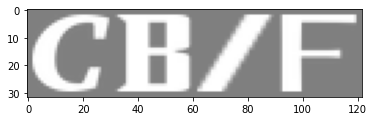

    C     B     I     F


In [9]:
import matplotlib.pyplot as plt
import numpy as np

classes = os.listdir(train_path)
print(classes) # only 10 alphabets
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Building our Model
The first layer of a model has the parameter in_channels=3 since the png image is a RGB image, out_channel is the number of nodes for the current layer, which we chose to be 32. After this we apply the ReLU activation function on the output of the previous layer. Layers 3&4, 5&6 repeat the steps above, where the in_channel is the out_channel of the last convulutional layer and the out_channels is half of the current in_channels. Next, layer 7 applies the Max pooling function on the output, reducing the size of the data. This reduces model fitting time and helps to avoid overfitting. The next layer flattens the matrix into a vector. Layers 9,10,11 apply a linear transformation reducing the output into a vector of size 10. If we apply the softmax function on these we will get the probabilities for the image being classified to each class. 


In [11]:
#Dense cnn
model = torch.nn.Sequential(
    
    # layers 1-6
    torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),  
    torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    
    # layers 7,8
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    
    # layers 9,10,11
    torch.nn.Linear(968, 512),
    torch.nn.Linear(512, 128),
    torch.nn.Linear(128, 10), 

)

### Model Training
Our loss function will be the multiclass class entropy function. the optimizer uses the Adam model to minimize this loss, we chose a learning rate similar to the one we used for the MINST dataset since they are both similar in style. We determine that 10 epochs provides a good balance between over/under fitting the model, given our learning rate. Next for each batch of data from the train_dataloader we first set our optimizers weights to zero with zero_grad(). Next we get the predicted probabilites (transformed by torch.nn.linear) for each class for that batch of data. We then calculate loss based on this output and the true label for the training data set. Next, loss.backward() is the back propgation step that finds the updates for our parameters and optimizer.step() actually updates the parameters.


In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# model.to(device)
for epoch in range(10):
    for data in train_loader:
        image, label = data
#         image = image.to(device)
#         label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    print(epoch, loss)

0 tensor(0.0189, grad_fn=<NllLossBackward0>)
1 tensor(0.0371, grad_fn=<NllLossBackward0>)
2 tensor(0.0187, grad_fn=<NllLossBackward0>)
3 tensor(0.0019, grad_fn=<NllLossBackward0>)
4 tensor(0.2212, grad_fn=<NllLossBackward0>)
5 tensor(0.0017, grad_fn=<NllLossBackward0>)
6 tensor(0.0911, grad_fn=<NllLossBackward0>)
7 tensor(2.7942e-05, grad_fn=<NllLossBackward0>)
8 tensor(0.6959, grad_fn=<NllLossBackward0>)
9 tensor(0.0003, grad_fn=<NllLossBackward0>)


### Testing the Model
The torch.no_grad() function disables gradient calculations over the weights (note: this will NOT affect the accuracy of the model) reducing memory consumption. Next we get all the batches of data from the test_loader, and get the raw output from the model (after the CrossEntropyFunction applies the softmax on the raw output of the CNN we get the probabilites) for each class. Then using the torch.max() function we get the maximum value from the tensors (returns both value and index). We increment total number of imagess (this will be 10,000 at the end) and also increment the number of images correctly classified for that particular batch of images. Finally we calculate the test accuracy by dividing the total correctly classified images by total images.

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0], data[1]
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted[1] == labels).sum().item()
print("Test accuracy: ", correct / total)

Test accuracy:  0.9292553191489362


### Conclusion
While our crossentropy was very low when training 0.003, our final accuracy on the test set is lower than expected (0.93). This can be attributed to a multitude of factors, such as possible overfitting of the model, small training data set size, optimization/loss function, or just randomness. One way to improve this accuracy would be to simply try a larger variety of (suitable) combinations parameter/model types. 